In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import warnings
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.pipeline import make_pipeline, make_union
import sys
import lightgbm as lgb
warnings.filterwarnings(action="ignore")

In [4]:
#!pip install --target /content/drive/MyDrive/Colab\ Notebooks/my-modules/ pytorch-lightning

In [5]:
# local, GoogleColab
place = 'GoogleColab'

# path
# GoogleColab
if place == 'GoogleColab':
    path_input = '/content/drive/MyDrive/Colab Notebooks/ProbSpace/民泊サービスの宿泊料金予測/input'
    path_submission = '/content/drive/MyDrive/Colab Notebooks/ProbSpace/民泊サービスの宿泊料金予測/submission'
    path_preproc_lgb = '/content/drive/MyDrive/Colab Notebooks/ProbSpace/民泊サービスの宿泊料金予測/notebook/preproc_output/lgb'
    path_stacking = '/content/drive/MyDrive/Colab Notebooks/ProbSpace/民泊サービスの宿泊料金予測/notebook/stacking'

    sys.path.append('/content/drive/MyDrive/Colab Notebooks/my-modules/')

# local
elif place == 'local':
    path_input = '../input'
    path_submission = '../submission'

In [6]:
# path
train_features_path = f"{path_preproc_lgb}/train_features.pickle"
test_features_path = f"{path_preproc_lgb}/test_features.pickle"
train_target_path = f"{path_preproc_lgb}/train_target.pickle"
obj_col_list_path = f"{path_preproc_lgb}/obj_col_list.pickle"
test_id_path = f"{path_preproc_lgb}/test_id_path.pickle"

In [36]:
with open(train_features_path, 'rb') as p:
    train_features = pickle.load(p)

with open(test_features_path, 'rb') as p:
    test_features = pickle.load(p)

with open(train_target_path, 'rb') as p:
    train_target = pickle.load(p)

with open(obj_col_list_path, 'rb') as p:
    obj_col_list = pickle.load(p)

with open(test_id_path, 'rb') as p:
    test_id = pickle.load(p)

print(f'train_features : {train_features.shape}')
print(f'test_features :{test_features.shape}')
print(f'train_target :{train_target.shape}')
print(f'obj_col_list :{obj_col_list.shape}')
print(f'test_id :{test_id.shape}')

train_features : (9889, 697)
test_features :(4996, 697)
train_target :(9889,)
obj_col_list :(5,)
test_id :(4996,)


### train, testデータに分割

In [37]:
from sklearn.model_selection import train_test_split

# featureとtargetに分ける
X = train_features
y = train_target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [38]:
# path
y_train_path = f"{path_stacking}/y_train.pickle"
y_test_path = f"{path_stacking}/y_test.pickle"

from pathlib import Path
for path in [y_train_path, y_test_path]:
    myfile = Path(path)
    myfile.touch(exist_ok=True)

with open(y_train_path, 'wb') as p:
    pickle.dump(y_train, p)

with open(y_test_path, 'wb') as p:
    pickle.dump(y_test, p)

## lightgbm

## Grid Search

In [39]:
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# from sklearn.metrics import mean_squared_error

# tr_x, va_x, tr_y, va_y = train_test_split(X_train, y_train, random_state=0, test_size=0.2)

# def score(params):
#     # パラメータを与えたときに最小化する評価指標を指定する
#     # 具体的には、モデルにパラメータを指定して学習・予測させた場合のスコアを返すようにする

#     # max_leavesの型を整数型に修正する
#     params['max_leaves'] = int(params['max_leaves'])

#     # Modelクラスを定義しているものとする
#     # Modelクラスは、fitで学習し、predictで予測値の確率を出力する
#     model = lgb.LGBMRegressor(**params)
#     model.fit(
#         tr_x,
#         tr_y,
#         eval_names=["train", "valid"],
#         eval_set=[(tr_x, tr_y), (va_x, va_y)],
#         verbose=0,
#         categorical_feature=list(obj_col_list),
#         #callbacks=[lgb.callback.record_evaluation(evals_result)],
#     )
#     va_pred = model.predict(va_x)
#     score = np.sqrt(mean_squared_error(va_y, va_pred))
#     print(f'params: {params}, rmse: {score:.4f}')

#     # 情報を記録しておく
#     history.append((params, score))

#     return {'loss': score, 'status': STATUS_OK}


# # 探索するパラメータの空間を指定する
# param_space = {
#     "boosting_type": "gbdt",
#     "objective": "regression",
#     "metric": "rmse",
#     "eta": 0.1,
#     "random_state": 0,
#     #"early_stopping_rounds": 100,
#     #"num_boost_round": 5000,
#     "verbosity": -1,
#     "n_jobs": -1,
#     'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
#     'max_leaves': hp.quniform('max_leaves', 0, 100, 10),
#     'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
#     'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
#     'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
#     # 余裕があればalpha, lambdaも調整する
#     'alpha' : hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
#     'lambda' : hp.loguniform('lambda', np.log(1e-6), np.log(10.0)),
# }

# # hyperoptによるパラメータ探索の実行
# max_evals = 30
# trials = Trials()
# history = []
# fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

# # 記録した情報からパラメータとスコアを出力する
# # （trialsからも情報が取得できるが、パラメータの取得がやや行いづらいため）
# history = sorted(history, key=lambda tpl: tpl[1])
# best = history[0]
# print(f'best params:{best[0]}, score:{best[1]:.4f}')

クロスバリデーション

In [40]:
params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "eta": 0.1,
    "gamma": 0.0,
    "alpha": 0.000001,
    "lambda": 1.0,
    "min_child_weight": 1,
    "max_leaves": 40,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 0,
    "verbosity": -1,
    "n_jobs": -1,
    "early_stopping_rounds": 100,
    "num_boost_round": 5000,
}

In [41]:
import lightgbm as lgb
from sklearn.model_selection import KFold

df_results = pd.DataFrame(
    index=[], columns=["best_score_train", "best_score_valid"],
)

models = []
evals_results = []
preds = []
preds_test = []
va_idxes = []

kf = KFold(n_splits=10, shuffle=True, random_state=0)
for tr_idx, va_idx in kf.split(X_train):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    evals_result = {}

    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_tr,
        y_tr,
        eval_names=["train", "valid"],
        eval_set=[(X_tr, y_tr), (X_va, y_va)],
        verbose=300,
        categorical_feature=list(obj_col_list ),
        callbacks=[lgb.callback.record_evaluation(evals_result)],
    )

    df_results.loc[len(df_results)] = [
        model.best_score_["train"]["rmse"],
        model.best_score_["valid"]["rmse"],
    ]

    models.append(model)
    evals_results.append(evals_result)

    # 予測値とインデックスを保存
    pred = model.predict(X_va)
    preds.append(pred)
    pred_test = model.predict(X_test)
    preds_test.append(pred_test)
    va_idxes.append(va_idx)

print("\ndone.")

Training until validation scores don't improve for 100 rounds.
[300]	train's rmse: 0.122066	valid's rmse: 0.542795
Early stopping, best iteration is:
[321]	train's rmse: 0.114086	valid's rmse: 0.541842
Training until validation scores don't improve for 100 rounds.
[300]	train's rmse: 0.1258	valid's rmse: 0.550469
[600]	train's rmse: 0.0578578	valid's rmse: 0.547734
Early stopping, best iteration is:
[601]	train's rmse: 0.0577134	valid's rmse: 0.547722
Training until validation scores don't improve for 100 rounds.
[300]	train's rmse: 0.126635	valid's rmse: 0.496079
[600]	train's rmse: 0.0583165	valid's rmse: 0.494085
Early stopping, best iteration is:
[667]	train's rmse: 0.0508806	valid's rmse: 0.493374
Training until validation scores don't improve for 100 rounds.
[300]	train's rmse: 0.1274	valid's rmse: 0.525836
[600]	train's rmse: 0.0581344	valid's rmse: 0.52255
Early stopping, best iteration is:
[627]	train's rmse: 0.0549806	valid's rmse: 0.522278
Training until validation scores do

In [42]:
df_results

best_score_train  best_score_valid
0          0.114086          0.541842
1          0.057713          0.547722
2          0.050881          0.493374
3          0.054981          0.522278
4          0.133094          0.503424
5          0.047585          0.512247
6          0.100320          0.520852
7          0.046759          0.525536
8          0.057066          0.518344
9          0.070270          0.505381

In [43]:
best_model = models[np.argmin(df_results.best_score_valid)]

testデータでのスコアの確認

In [44]:
def mean_predict(models, data):
    df_tmp = pd.DataFrame()
    for i in range(len(models)):
        df_tmp[f"model{i}"] = models[i].predict(data)

    return df_tmp.mean(axis=1).values

In [45]:
from sklearn.metrics import mean_squared_error

for i in range(len(models)):
    pred = models[i].predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, pred))
    print(f"model{i}: {score}")

# ensemble_predictの追加
pred = mean_predict(models, X_test)
score = np.sqrt(mean_squared_error(y_test, pred))
print(f"model_mean: {score}")

model0: 0.49603629243306924
model1: 0.4965027584300668
model2: 0.48784489918179813
model3: 0.4846685990142862
model4: 0.4920052831179146
model5: 0.4972129558314451
model6: 0.49778435969081963
model7: 0.49157382575179953
model8: 0.4901286996358272
model9: 0.49112568948195595
model_mean: 0.4744022064886614


testデータ作成

In [46]:
test_features.head()

host_id  neighbourhood  room_type  minimum_nights  number_of_reviews  \
0       12             13          2             1.0                  0   
1        1              7          1             3.0                 21   
2       23              9          1             1.0                 14   
3        6              7          1             1.0                 16   
4        7              2          1             4.0                  2   

   reviews_per_month  availability_365  last_review_year  last_review_month  \
0                NaN               183               NaN                NaN   
1               1.94               337            2020.0                4.0   
2               0.82               240            2020.0                2.0   
3               1.19                 0            2020.0                2.0   
4               0.19               164            2019.0                7.0   

   last_review_day  ...  name_tfidf_nmf_54  name_tfidf_nmf_55  \
0              NaN  ...                0.0           0.000777   
1             16.0  ...                0.0           0.001172   
2             12.0  ...                0.0           0.000000   
3             17.0  ...                0.0           0.000000   
4             21.0  ...                0.0           0.000000   

   name_tfidf_nmf_56  name_tfidf_nmf_57  name_tfidf_nmf_58  name_tfidf_nmf_59  \
0                0.0           0.000000           0.003473           0.083863   
1                0.0           0.000000           0.004297           0.001151   
2                0.0           0.000500           0.000000           0.000000   
3                0.0           0.000000           0.000000           0.000000   
4                0.0           0.003089           0.000000           0.000000   

   name_tfidf_nmf_60  name_tfidf_nmf_61  name_tfidf_nmf_62  name_tfidf_nmf_63  
0           0.000000           0.000000           0.000000           0.000000  
1           0.000000           0.000000           0.000000           0.000000  
2           0.001762           0.000775           0.000000           0.000000  
3           0.000859           0.000000           0.000000           0.000000  
4           0.004715           0.000000           0.004451           0.113749  

[5 rows x 697 columns]

サブミット

In [47]:
pred_submit = mean_predict(models, test_features)

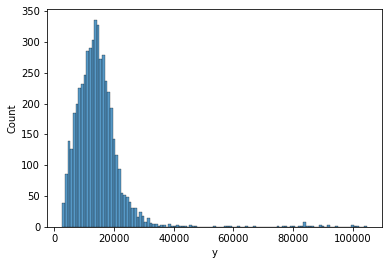

In [48]:
df_submit = pd.DataFrame({"id": test_id, "y": np.expm1(pred_submit)})
sns.histplot(df_submit.y)

In [49]:
import datetime

today = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

df_submit.to_csv(f"{path_submission}/{today}.csv", index=False)

## Stacking用に予測値をpickle保存

In [50]:
# path
lgb_pred_train_path = f"{path_stacking}/lgb_pred_train.pickle"
lgb_pred_test_path = f"{path_stacking}/lgb_pred_test.pickle"
lgb_pred_submit_path = f"{path_stacking}/lgb_pred_submit.pickle"

In [51]:
from pathlib import Path
for path in [lgb_pred_train_path, lgb_pred_test_path, lgb_pred_submit_path]:
    myfile = Path(path)
    myfile.touch(exist_ok=True)

In [52]:
# バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
va_idxes_ = np.concatenate(va_idxes)
preds_ = np.concatenate(preds, axis=0)
order = np.argsort(va_idxes_)
pred_train = preds_[order]

# テストデータに対する予測値の平均をとる
pred_test = np.mean(preds_test, axis=0)

In [53]:
with open(lgb_pred_train_path, 'wb') as p:
    pickle.dump(pred_train, p)

with open(lgb_pred_test_path, 'wb') as p:
    pickle.dump(pred_test, p)
    
with open(lgb_pred_submit_path, 'wb') as p:
    pickle.dump(pred_submit, p)

## 変数重要度

### lightGBM

In [54]:
df_fi = pd.DataFrame(
    {"column": X.columns, "feature_importance": best_model.feature_importances_}
).sort_values("feature_importance", ascending=False)
df_fi.tail(20)

column  feature_importance
669                  name_tfidf_nmf_36                   3
665                  name_tfidf_nmf_32                   2
15   category_distance_nearest_station                   2
32                           name_hoyo                   2
27                      name_dormitory                   2
672                  name_tfidf_nmf_39                   1
690                  name_tfidf_nmf_57                   1
30               name_wifi|wi-fi|wi fi                   1
20               name_luxurious|luxury                   1
23                       name_playroom                   0
31                           name_cozy                   0
24                           name_美式大床                   0
25                            name_sky                   0
19                        name_biggest                   0
28                           name_semi                   0
26                              name_王                   0
18                   name_prem|premium                   0
17                          name_uhome                   0
21                          name_suite                   0
22                         name_direct                   0

In [55]:
sns.barplot(data=df_fi.head(15), x="feature_importance", y="column")

plt.show()

### dalex

In [56]:
import dalex as dx

model_exp = dx.Explainer(best_model, X_train, y_train)

Preparation of a new explainer is initiated

  -> data              : 7911 rows 697 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 7911 values
  -> model_class       : lightgbm.sklearn.LGBMRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7f2051f3d680> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 6.85, mean = 9.43, max = 12.4
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.74, mean = 0.00259, max = 2.77
  -> model_info        : package lightgbm

A new explainer has been created!


In [57]:
mp_model = model_exp.model_parts()

In [58]:
mp_model.plot()

In [59]:
mp_model.result.sort_values("dropout_loss", ascending=False)

variable  dropout_loss          label
698             _baseline_      1.264197  LGBMRegressor
697        nearest_station      0.464584  LGBMRegressor
696              room_type      0.462103  LGBMRegressor
695                host_id      0.229246  LGBMRegressor
694          neighbourhood      0.228048  LGBMRegressor
..                     ...           ...            ...
4    name_luxurious|luxury      0.171754  LGBMRegressor
3        name_tfidf_nmf_53      0.171751  LGBMRegressor
2       name_tfidf_svd_258      0.171749  LGBMRegressor
1       name_tfidf_svd_209      0.171742  LGBMRegressor
0       name_tfidf_svd_408      0.171726  LGBMRegressor

[699 rows x 3 columns]